In [1]:
import os
import pandas as pd
import numpy as np
import csv

from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import cross_val_score
from sklearn import metrics
from sklearn.metrics import confusion_matrix
from sklearn.utils import shuffle
from sklearn.model_selection import cross_val_predict

from PIL import Image
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
# read AML Dependent data for training
dependent_data_2024_subjects= pd.read_csv("Dependent_Data_2024_subjects_with_bloodsource_info_from_2761_expression_arrays_after_BECorrection.csv", index_col = [0]).transpose() 

In [3]:
print(dependent_data_2024_subjects.shape)

(2024, 44754)


In [4]:
dependent_data_2024_subjects.head()

,1007_s_at,1053_at,117_at,121_at,1255_g_at,1294_at,1316_at,1320_at,1405_i_at,1431_at,...,AFFX-r2-Ec-bioD-3_at,AFFX-r2-Ec-bioD-5_at,AFFX-r2-P1-cre-3_at,AFFX-r2-P1-cre-5_at,AFFX-ThrX-3_at,AFFX-ThrX-5_at,AFFX-ThrX-M_at,AFFX-TrpnX-3_at,AFFX-TrpnX-5_at,AFFX-TrpnX-M_at
GSM259087,0.514315,0.976952,0.204111,0.874157,-1.271232,1.461407,-0.193213,-0.740675,1.144320,-0.889499,...,1.708256,1.609794,2.064453,2.025612,-0.158628,-0.645428,-0.776368,-1.523518,-0.999196,-1.201138
GSM259088,0.032696,1.014619,0.202421,0.911459,-1.313277,1.518420,-0.041074,-0.592220,1.500677,-0.999256,...,1.774086,1.681039,2.115362,2.100730,-0.254606,-0.676889,-0.928041,-1.491960,-1.259444,-1.040317
GSM259089,0.472013,0.144371,0.077756,1.005632,-1.501279,1.222752,-0.067396,-0.677869,1.557750,-1.088957,...,1.828789,1.748572,2.180082,2.151882,-0.323624,-0.755990,-0.880334,-1.759424,-1.108884,-1.166864
GSM259090,0.493673,0.753012,0.214856,0.834018,-1.415068,1.368582,-0.098122,-0.488232,0.633590,-1.249102,...,1.866441,1.780234,2.181288,2.154576,-0.369476,-0.590533,-0.936734,-1.424813,-1.115401,-1.220137
GSM259091,0.198074,0.806025,0.213305,0.808930,-1.578589,1.439793,-0.062678,-0.742135,1.435615,-0.944112,...,1.768924,1.687821,2.141684,2.107009,-0.246674,-0.720547,-0.897988,-1.692737,-1.224409,-1.280189


In [5]:
# read AML Target data for training
# bm (bone marrow)=0 and pb (peripheral blood)=1
target_data_2024_subjects = pd.read_csv("Target_Data_2024_subjects_with_bloodsource_info_from_2761_expression_arrays_after_BECorrection.csv")

In [6]:
print(target_data_2024_subjects.shape)

(2024, 2)


In [7]:
target_data_2024_subjects.head()

,Unnamed: 0,target
0,GSM259087,0.0
1,GSM259088,0.0
2,GSM259089,0.0
3,GSM259090,0.0
4,GSM259091,0.0


In [8]:
target_data_2024_subjects_y = target_data_2024_subjects["target"].values
target_data_2024_subjects_y

array([0., 0., 0., ..., 1., 1., 1.])

In [9]:
# set algorthm parameters -- using one-vs-rest scheme (multi_class=ovr)
lr_classifier = LogisticRegression(penalty="l2", multi_class="ovr", solver="liblinear", 
                                   max_iter=100, tol=0.0001, intercept_scaling=1.0, verbose=0, 
                                   n_jobs=1, C=1.0, fit_intercept=True, dual=False, 
                                   warm_start=False, class_weight=None)

In [10]:
scores = cross_val_score (lr_classifier, dependent_data_2024_subjects, target_data_2024_subjects_y,
                          cv = 10, scoring="accuracy")
print("Accuracy: %0.2f (+/- %0.2f)" % (scores.mean() * 100, scores.std() * 2))

Accuracy: 90.82 (+/- 0.20)


In [11]:
# trains and tests the model over 10 folds to prevent over-fitting and shuffle matrices randomly
X, y = shuffle(dependent_data_2024_subjects, target_data_2024_subjects_y, random_state = None)    
predict = cross_val_predict (lr_classifier, X, y, cv = 10)

In [12]:
# AUC (Area under the ROC Curve) ranges from 0 (worst) to 1 (best)
auc_score = metrics.roc_auc_score(y, predict)
"AUC Score: %0.2f%%" % (auc_score * 100)

'AUC Score: 95.55%'

In [13]:
# calculates the accuracy score for the predicted labels against the true labels
accuracy_score = metrics.accuracy_score(y, predict) 
"Accuracy Score: %0.2f%%" % (accuracy_score * 100)

'Accuracy Score: 96.74%'

In [14]:
confusion_matrix_result = confusion_matrix(y,predict)
confusion_matrix_result

array([[1389,   20],
       [  46,  569]])

In [15]:
TP = confusion_matrix_result[1, 1]
TN = confusion_matrix_result[0, 0]
FP = confusion_matrix_result[0, 1]
FN = confusion_matrix_result[1, 0]

error = round((FP+FN)/(TP+TN+FP+FN)*100,2)
specificity = round(TN/(TN+FP)*100,2)
sensitivity = round(TP/(TP+FN)*100,2)
precision = round(TP/(TP+FP)*100,2)

In [16]:
import csv


fields=['Accuracy','Error',"Specificity","Sensitivity","Precision","AUC Score"]
with open(r'AML_BloodSource_LR-Classification_Traning_on_44754_ProbSets_from_2024_Subjects-Accuracy.csv', 'w') as f:
    writer = csv.writer(f)
    writer.writerow(fields)

confusion_matrix_result_List = ["Avg. Accuracy (%%): %0.2f (+/- %f)" % (scores.mean() * 100,
                                scores.std() * 2),
                                error, 
                                specificity,
                                sensitivity,
                                precision,
                               "AUC Score (%%): %0.2f" % (auc_score * 100)]
with open(r'AML_BloodSource_LR-Classification_Traning_on_44754_ProbSets_from_2024_Subjects-Accuracy.csv', 'a') as f:
    writer = csv.writer(f)
    writer.writerow(confusion_matrix_result_List)

In [17]:
cm = [[TN, FP],[FN ,TP]]

In [ ]:
# bm (bone marrow)=0 
# pb (peripheral blood)=1

<Figure size 1000x1000 with 0 Axes>

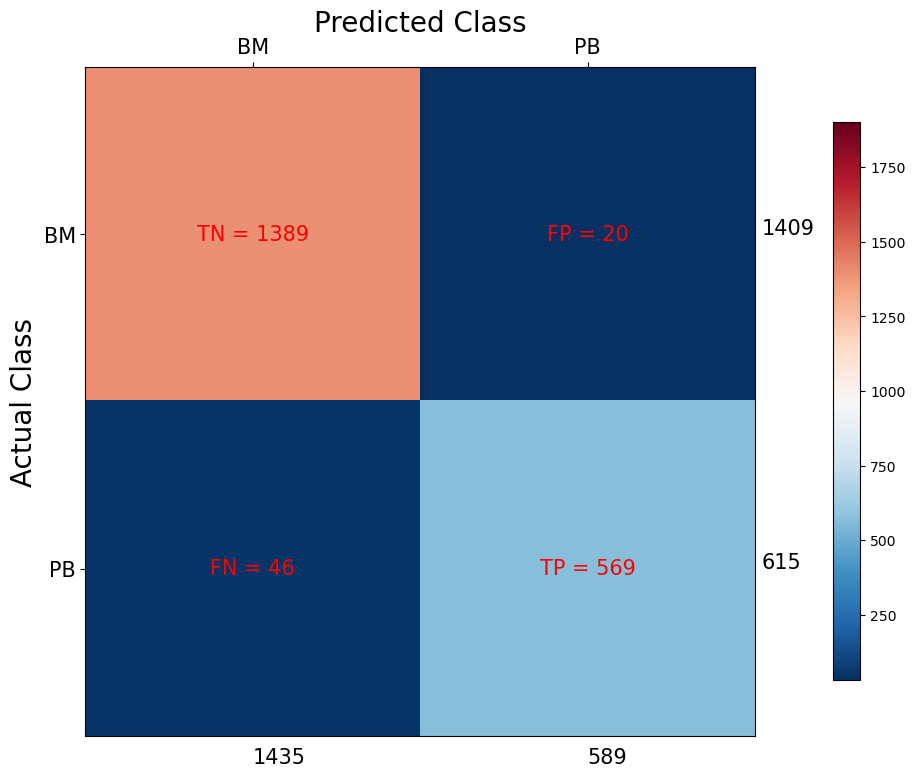

In [19]:
fig_size = plt.rcParams["figure.figsize"] 
fig_size[0] = 10  
fig_size[1] = 10

plt.figure()


fig, ax = plt.subplots()
im = ax.imshow(cm, interpolation='nearest', cmap=plt.cm.get_cmap("RdBu_r"), vmin=30, vmax=1900)
classNames = ['BM','PB']
plt.ylabel('Actual Class',fontsize=20)



plt.rcParams['xtick.bottom'] = plt.rcParams['xtick.labelbottom'] = False
plt.rcParams['xtick.top'] = plt.rcParams['xtick.labeltop'] = True
plt.xlabel('Predicted Class' ,fontsize=20)


tick_marks = np.arange(len(classNames))
plt.xticks(tick_marks, classNames,fontsize=15, rotation=0)
plt.yticks(tick_marks, classNames,fontsize=15)
s = [['TN','FP'], ['FN', 'TP']]
for i in range(2):
    for j in range(2):
        plt.text(j,i, str(s[i][j])+" = "+str(cm[i][j]),fontsize=15,ha='center', va='center',color="r")

plt.text(1.52,0, str(TN+FP),fontsize=15)
plt.text(1.52,1, str(FN+TP),fontsize=15)
plt.text(0,1.58, str(TN+FN),fontsize=15)
plt.text(1,1.58, str(FP+TP),fontsize=15)

ax.xaxis.set_label_position('top') 



fig.colorbar(im, fraction=0.036, pad=0.1)


title = "AML_BloodSource_LR-Classification_Traning_on_44754_ProbSets_from_2024_Subjects-Confusion_Matrix.png"


plt.savefig(title,bbox_inches='tight')
plt.show() 


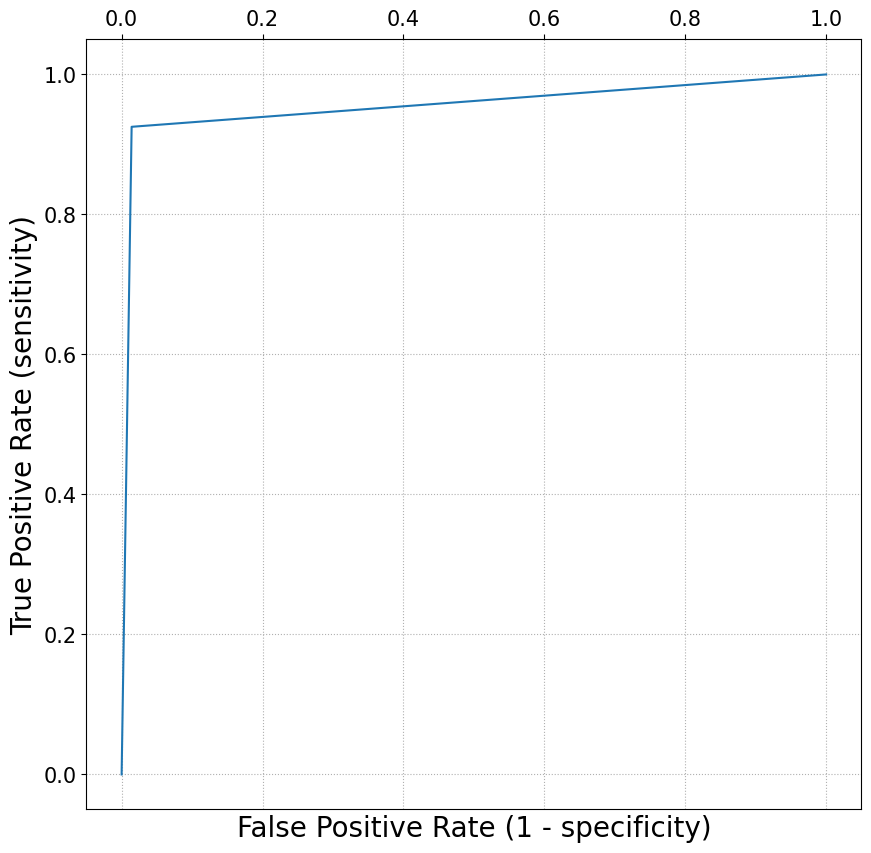

In [20]:


fig_size = plt.rcParams["figure.figsize"] 
fig_size[0] = 10  
fig_size[1] = 10




fpr, tpr, thresholds = metrics.roc_curve(y, predict)
metrics.auc(fpr, tpr)
plt.plot(fpr, tpr)
plt.xlabel('False Positive Rate (1 - specificity)',fontsize=20)
plt.ylabel('True Positive Rate (sensitivity)',fontsize=20)

plt.xticks(fontsize=15)
plt.yticks(fontsize=15)


# plt.title('ROC curve for AML KNN-classifier')
plt.grid(linestyle='dotted')




title = "AML_BloodSource_LR-Classification_Traning_on_44754_ProbSets_from_2024_Subjects-ROC_Curve.png"


plt.savefig(title,bbox_inches='tight')
plt.show() 